# SIR-X

This notebook exemplifies how Open-SIR can be used to fit the SIR-X model by [Maier and Dirk (2020)](https://science.sciencemag.org/content/early/2020/04/07/science.abb4557.full) to existing data and make predictions. The SIR-X model is a standard generalization of the Susceptible-Infectious-Removed (SIR) model, which includes the influence of exogenous factors such as policy changes, lockdown of the whole population and quarantine of the infectious individuals.

The Open-SIR implementation of the SIR-X model will be validated reproducing the parameter fitting published in the [supplementary material](https://science.sciencemag.org/cgi/content/full/science.abb4557/DC1) of the original article published by [Maier and Brockmann (2020)](https://science.sciencemag.org/content/early/2020/04/07/science.abb4557.full). For simplicity, the validation will be performed only for the city of Guangdong, China.

## Import modules

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Data sourcing

We will source data from the repository of the [John Hopkins University COVID-19 dashboard] (https://coronavirus.jhu.edu/map.html) published formally as a correspondence in [The Lancet](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30120-1/fulltext#seccestitle10). This time series data contains the number of reported cases $C(t)$ per day for a number of cities.



In [2]:
# Source data from John Hokpins university reposotiry
# jhu_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/who_covid_19_situation_reports/who_covid_19_sit_rep_time_series/who_covid_19_sit_rep_time_series.csv"
jhu_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
jhu_df = pd.read_csv(jhu_link)
# Explore the dataset
jhu_df.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,32951,33190,33384,33594,33908,34194,34366,34451,34455,34740
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,2893,2964,3038,3106,3188,3278,3371,3454,3571,3667
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,15941,16404,16879,17348,17808,18242,18712,19195,19689,20216
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,858,861
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,346,346,386,386,396,458,462,506,525,541
5,NaN,Antigua and Barbuda,17.06080,-61.796400,0,0,0,0,0,0,...,68,70,70,70,73,74,74,74,74,74
6,NaN,Argentina,-38.41610,-63.616700,0,0,0,0,0,0,...,77815,80447,83426,87030,90693,94060,97509,100166,103265,106910
7,NaN,Armenia,40.06910,45.038200,0,0,0,0,0,0,...,28606,28936,29285,29820,30346,30903,31392,31969,32151,32490
8,Australian Capital Territory,Australia,-35.47350,149.012400,0,0,0,0,0,0,...,108,108,111,112,113,113,113,113,113,113
9,New South Wales,Australia,-33.86880,151.209300,0,0,0,0,3,4,...,3429,3433,3440,3453,3467,3474,3478,3492,3505,3517


It is observed that the column "Province/States" contains the name of the cities, and since the forth column a time series stamp (or index) is provided to record daily data of reported cases. Additionally, there are many days without recorded data for a number of chinese cities. This won't be an issue for parameter fitting as Open-SIR doesn't require uniform spacement of the observed data.

### Data preparation

In the following lines, the time series for Guangdong reported cases $C(t)$ is extracted from the original dataframe. Thereafter, the columns are converted to a pandas date time index in order to perform further data preparation steps.

In [3]:
China = jhu_df[jhu_df[jhu_df.columns[1]]=="China"]
city_name = "Guangdong"
city = China[China["Province/State"] == city_name]
city = city.drop(columns=["Province/State", "Country/Region", "Lat","Long"])
time_index = pd.to_datetime(city.columns)
data = city.values
# Visualize the time
ts = pd.Series(data = city.values[0], index = time_index)

Using the function ts.plot() a quick visualization of the dataset is obtained:

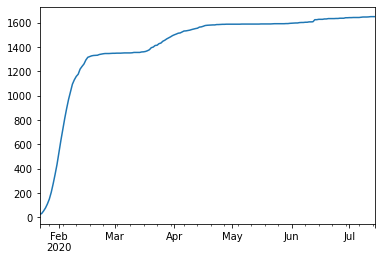

In [4]:
ts.plot()
plt.show()

Data cleaning

In [5]:
ts_clean = ts.dropna()
# Extract data
ts_fit = ts_clean['2020-01-21':"2020-02-12"]
# Convert index to numeric
ts_num = pd.to_numeric(ts_fit.index)
t0 = ts_num[0]
# Convert datetime to days
t_days = (ts_num-t0)/(10**9*86400)
t_days = t_days.astype(int).values
# t_days is an input for SIR

In [6]:
# Define the X number
nX = ts_fit.values # Number of infected
N = 104.3e6 # Population size of Guangdong

Exploration of the dataset

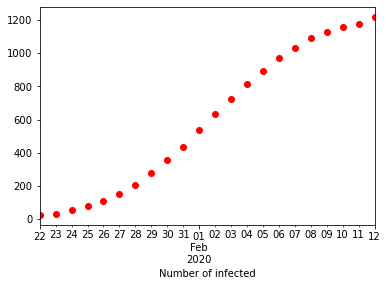

In [7]:
ts_fit.plot(style='ro')
plt.xlabel("Number of infected")
plt.show()

### Setting up SIR and SIR-X models

The population $N$ of the city is a necessary input for the model. In this notebook, this was hardocded, but it can be sourced directly from a web source.

Note that whilst the SIR model estimates directly the number of infected people, $N I(t)$, SIR-X estimates the number of infected people based on the number of tested cases that are in quarantine or in an hospital $N X(t)$

In [8]:
# These lines are required only if opensir wasn't installed using pip install, or if opensir is running in the pipenv virtual environment
import sys
path_opensir = '../../'
sys.path.append(path_opensir)

# Import SIR and SIRX models
from opensir.models import SIR, SIRX
nX = ts_fit.values # Number of observed infections of the time series
N = 104.3e6 # Population size of Guangdong
params = [0.95, 0.38]
w0 = (N-nX[0], nX[0], 0)

G_sir = SIR()
G_sir.set_params(p=params, initial_conds=w0)
G_sir.fit_input=2
G_sir.fit(t_days, nX)
G_sir.solve(t_days[-1], t_days[-1]+1)
t_SIR = G_sir.fetch()[:,0]
I_SIR = G_sir.fetch()[:,2]

### Try to fit a SIR model to Guangdong data

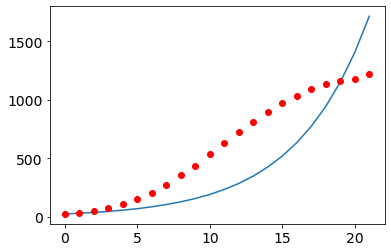

In [9]:
ax = plt.axes()
ax.tick_params(axis="both", which="major", labelsize= 14 )
plt.plot(t_SIR, I_SIR)
plt.plot(t_days, nX, 'ro')
plt.show()

The SIR model is clearly not appropriate to fit this data, as it cannot resolve the effect of exogeneous containment efforts such as quarantines or lockdown. We will repeat the process with a SIR-X model.

In [10]:
g_sirx = SIRX()
params = [6.2/8, 1/8, 0.05, 0.05, 5]
# X_0 can be directly ontained from the statistics
n_x0 = nX[0]            # Number of people tested positive
n_i0 = nX[0]

w0 = (N-n_x0-n_i0, n_i0, 0, n_x0)
g_sirx.set_params(p=params, initial_conds=w0)
# Fit all parameters
fit_index=[False, False, True, True, True]
g_sirx.fit(t_days, nX, fit_index = fit_index)
g_sirx.solve(t_days[-1], t_days[-1]+1)
t_sirx = g_sirx.fetch()[:,0]
inf_sirx = g_sirx.fetch()[:,4]

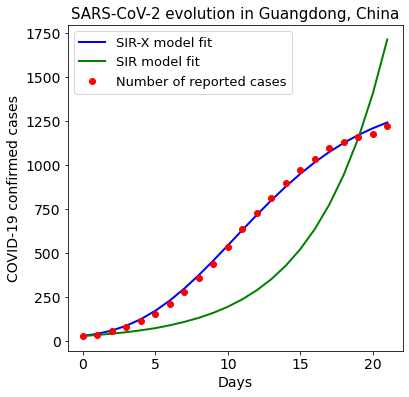

In [11]:
plt.figure(figsize=[6,6])
ax = plt.axes()
plt.plot(t_sirx, inf_sirx, 'b-', linewidth=2)
plt.plot(t_SIR, I_SIR,'g-', linewidth=2)
plt.plot(t_days, nX, 'ro')
plt.legend(["SIR-X model fit", "SIR model fit", "Number of reported cases"], fontsize=13)
plt.title("SARS-CoV-2 evolution in Guangdong, China", size=15)
plt.xlabel('Days', fontsize=14)
plt.ylabel('COVID-19 confirmed cases', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

After fitting the parameters, the effective infectious period $T_{I,eff}$ and the effective reproduction rate $R_{0,eff}$ can be obtained from the model properties

$$T_{I,eff} = (\beta + \kappa + \kappa_0)^{-1}$$
$$R_{0,eff} = \alpha T_{I,eff}$$

Aditionally, the Public containment leverage $P$ and the quarantine probability $Q$ can be calculated through:

$$P = \frac{\kappa_0}{\kappa_0 + \kappa}$$
$$Q = \frac{\kappa_0 + \kappa}{\beta + \kappa_0 + \kappa}$$

In [12]:
print("Effective infectious period T_I_eff =  %.2f days " % g_sirx.t_inf_eff )
print("Effective reproduction rate R_0_eff =  %.2f, Maier and Brockmann = %.2f" % (g_sirx.r0_eff, 3.02))
print("Public containment leverage =  %.2f, Maier and Brockmann = %.2f" % (g_sirx.pcl, 0.75))
print("Quarantine probability =  %.2f, Maier and Brockmann = %.2f" % (g_sirx.q_prob, 0.51))

Effective infectious period T_I_eff =  3.88 days 
Effective reproduction rate R_0_eff =  3.01, Maier and Brockmann = 3.02
Public containment leverage =  0.79, Maier and Brockmann = 0.75
Quarantine probability =  0.52, Maier and Brockmann = 0.51


### Calculation of predictive confidence intervals

The confidence intervals on the predictions of the SIR-X model can be calculated using a block cross validation. This technique is widely used in Time Series Analysis. In the open-sir API, the function `model.ci_block_cv` calculates the average mean squared error of the predictions, a list of the rolling mean squared errors and the list of parameters which shows how much each parameter changes taking different number of days for making predictions.

The three first parameters are the same as the fit function, while the last two parameters are the `lags` and the `min_sample`. The `lags` parameter indicates how many periods in the future will be forecasted in order to calculate the mean squared error of the model prediction. The `min_sample` parameter indicates the initial number of observations and days that will be taken to perform the block cross validation.

In the following example, `model.ci_block_cv` is used to estimate the average mean squared error of *1-day* predictions taking *6* observations as the starting point of the cross validation. For Guangdong, a `min_sample=6` higher than the default 3 is required to handle well the missing data. This way, both the data on the four first days, and two days after the data starts again, are considered for cross validation.

In [13]:
# Calculate confidence intervals
mse_avg, mse_list, p_list, pred_data = g_sirx.block_cv(lags = 1, min_sample = 6)

If it is assumed that the residuals distribute normally, then a good estimation of a 95% confidence interval on the one-day prediction of the number of confirmed cases is 

$$\sigma \sim \mathrm{MSE} \rightarrow n_{X,{t+1}} \sim \hat{n}_{X,{t+1}} \pm 2 \sigma$$ 

Where $n_{X,{t+1}}$ is the real number of confirmed cases in the next day, and $\hat{n}_{X,{t+1}}$ is the estimation using the SIR-X model using cross validation. We can use the `PredictionResults` instance `pred_data` functionality to explore the mean-squared errors and the predictions confidence intervals:

In [14]:
pred_data.print_mse()

Average MSE for 0-day predictions = 18.21, MSE sample size = 16
Average MSE for 1-day predictions = 28.94, MSE sample size = 15
Average MSE for 2-day predictions = 40.50, MSE sample size = 14
Average MSE for 3-day predictions = 55.46, MSE sample size = 13
Average MSE for 4-day predictions = 74.75, MSE sample size = 12
Average MSE for 5-day predictions = 96.88, MSE sample size = 11
Average MSE for 6-day predictions = 121.33, MSE sample size = 10
Average MSE for 7-day predictions = 148.01, MSE sample size = 9
Average MSE for 8-day predictions = 176.33, MSE sample size = 8
Average MSE for 9-day predictions = 204.69, MSE sample size = 7
Average MSE for 10-day predictions = 231.87, MSE sample size = 6
Average MSE for 11-day predictions = 255.87, MSE sample size = 5
Average MSE for 12-day predictions = 298.53, MSE sample size = 4
Average MSE for 13-day predictions = 289.29, MSE sample size = 3
Average MSE for 14-day predictions = 92.49, MSE sample size = 2
Average MSE for 15-day predictions 

The predictive accuracy of the model is quite impressive, even for 9-day predictions. Let's take advantage of the relatively low mean squared error to forecast a 10 days horizon with confidence intervals using `pred_data.plot_predictions(n_days=9)`

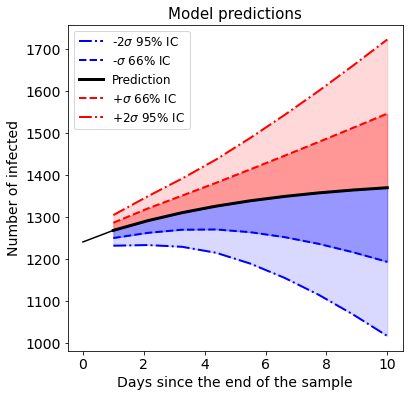

In [15]:
pred_data.plot_predictions(n_days=9)

If it is assumed that the residuals distribute normally, then a good estimation of a 95% confidence interval on the one-day prediction of the number of confirmed cases is 

$$\sigma \sim \mathrm{MSE} \rightarrow n_{X,{t+1}} \sim \hat{n}_{X,{t+1}} \pm 2 \sigma$$ 

Where $n_{X,{t+1}}$ is the real number of confirmed cases in the next day, and $\hat{n}_{X,{t+1}}$ is the estimation using the SIR-X model using cross validation. We use solve to make a 1-day prediction and append the 95% confidence interval.

In [16]:
# Predict
g_sirx.solve(t_days[-1]+1,t_days[-1]+2)
n_X_tplusone = g_sirx.fetch()[-1,4]
print("Estimation of n_X_{t+1} = %.0f +- %.0f " % (n_X_tplusone, 2*mse_avg[0]) )

Estimation of n_X_{t+1} = 1268 +- 36 


In [17]:
# Transform parameter list into a DataFrame
par_block_cv = pd.DataFrame(p_list)
# Rename dataframe columns based on SIR-X parameter names
par_block_cv.columns = g_sirx.PARAMS
# Add the day. Note that we take the days from min_sample until the end of the array, as days
# 0,1,2 are used for the first sampling in the block cross-validation
par_block_cv['Day'] = t_days[5:]
# Explore formatted dataframe for parametric analysis
par_block_cv.head(len(p_list))

,alpha,beta,kappa_0,kappa,inf_over_test,Day
0,0.775,0.125,0.115900,2.472714e-13,2.705770,5
1,0.775,0.125,0.109540,8.640802e-10,2.774669,6
2,0.775,0.125,0.065223,1.206344e-01,1.764604,7
3,0.775,0.125,0.082934,6.629895e-02,2.099931,8
4,0.775,0.125,0.104995,1.792900e-14,2.822296,9
5,0.775,0.125,0.089924,4.695617e-02,2.263911,10
6,0.775,0.125,0.092797,3.732302e-02,2.355464,11
7,0.775,0.125,0.104239,2.828441e-07,2.824631,12
8,0.775,0.125,0.105290,1.722384e-13,2.843347,13
9,0.775,0.125,0.106338,1.838751e-10,2.866021,14


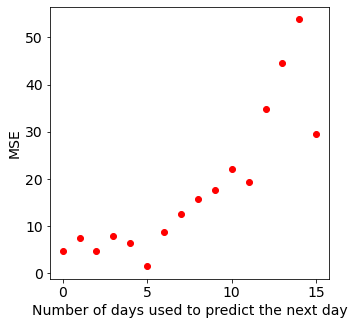

In [18]:
plt.figure(figsize = [5,5])
ax = plt.axes()
ax.tick_params(axis = "both", which = "major", labelsize = 14 )
plt.plot(mse_list[0],'ro')
plt.xlabel('Number of days used to predict the next day', size = 14)
plt.ylabel('MSE', size = 14)
plt.show()

There is an outlier on day 1, as this is when the missing date starts. A more reliable approach would be to take the last 8 values of the mean squared error to calculate a new average assuming that there will be no more missing data.

#### Variation of fitted parameters

Finally, it is possible to observe how the model parameters change as more days and number of confirmed cases are introduced in the block cross validation. 

It is clear to observe that after day 15 all parameters except kappa begin to converge. Therefore, care must be taken when performing inference over the parameter kappa.

### Long term prediction
Now we can use the model to predict when the peak will occur and what will be the maximum number of infected

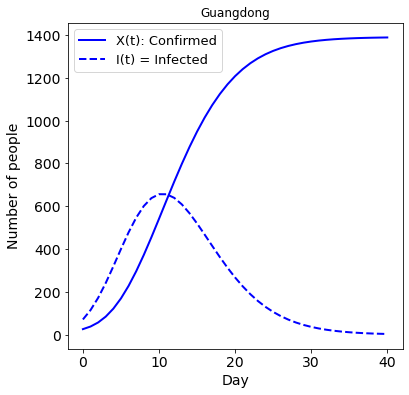

In [19]:
# Predict
plt.figure(figsize=[6,6])
ax = plt.axes()
ax.tick_params(axis="both", which="major", labelsize= 14 )
g_sirx.solve(40,41)
# Plot
plt.plot(g_sirx.fetch()[:,4], 'b-', linewidth=2) # X(t)
plt.plot(g_sirx.fetch()[:,2], 'b--', linewidth=2) # I(t)
plt.xlabel('Day', size=14)
plt.ylabel('Number of people', size=14)
plt.legend(["X(t): Confirmed","I(t) = Infected"], fontsize=13)
plt.title(city_name)
plt.show()

The model was trained with a limited amount of data. It is clear to observe that since the measures took place in Guangdong, at least 6 weeks of quarantine were necessary to control the pandemics. Note that a limitation of this model is that it predicts an equilibrium where the number of infected, denoted by the yellow line in the figure above, is 0 after a short time. In reality, this amount will decrease to a small number.

After the peak of infections is reached, it is necessary to keep the quarantine and effective contact tracing for at least 30 days more.

### Validate using model.plot()

The function `model.plot()` offers a handy way to visualize model fitting and predictions. Custom visualizations can be validated against the `model.plot()` function.

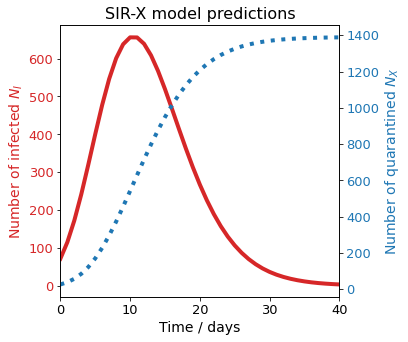

In [20]:
g_sirx.plot()

Looking at the values of the number of infected and quarantined individuals, as well as the time of the peak, it is clear that both plots are in good agreement, which validates the customized plot created by the code cell below "long term prediction".